# Introduction

The purpose of this jupyter notebook is to clean and process the data from US_Recalls, to then be able to generate insights in a Power BI report. Natural language processing is used on the dataset to extract key actions taken in every recall event. Finally the processed dataset is printed to a csv file, to visualise the data using a Power BI dashboard.

# Step 0: Import Libraries

The first task is to import the libraries used for this analysis and data cleaning/extraction; the first set of libraries includes os, pandas, missingno, and matplotlib.pyplot, which are commonly used for data analysis and visualization.

The second set of libraries, string, json and collections, are used for text manipulation tasks, such as cleaning and formatting text data.

The last set of libraries, re, nltk, and textblob, are commonly used in natural language processing (NLP) tasks, such as text classification, sentiment analysis, and language modeling.

In [1]:
#basic DS libraries
import os
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt 

#text manipulation
import string
import json
from collections import Counter

#NLP libraries
import re
import nltk
import textblob


# Step 1: Import Data

In [2]:
#Setting directory
dir_name = r'C:\Users\jlenehan\OneDrive - Intel Corporation\Documents\0 - Data Science\Projects\Auto Recalls\Auto-Recalls'
os.chdir(dir_name)

In [3]:
#Recalls Data
csv_url = "https://datahub.transportation.gov/resource/6axg-epim.csv?$limit=1000000"

recalls_raw = pd.read_csv(csv_url)

recalls_raw.head()

,report_received_date,nhtsa_id,recall_link,manufacturer,subject,component,mfr_campaign_number,recall_type,potentially_affected,defect_summary,consequence_summary,corrective_action,fire_risk_when_parked,do_not_drive
0,2023-03-10T00:00:00.000,23V161000,Go to Recall (https://www.nhtsa.gov/recalls?nh...,"Kibbi, LLC",Entry Door Latch Failure,LATCHES/LOCKS/LINKAGES,NR (Not Reported),Vehicle,63.0,"Kibbi, LLC (Kibbi) is recalling certain 2022-2...",The inability to enter or exit the vehicle in ...,Dealers will inspect and replace the door latc...,No,No
1,2023-03-10T00:00:00.000,23V162000,Go to Recall (https://www.nhtsa.gov/recalls?nh...,Ford Motor Company,Front Brake Hoses May Rupture,"SERVICE BRAKES, HYDRAULIC",23S12,Vehicle,1280726.0,Ford Motor Company (Ford) is recalling certain...,A brake fluid leak will increase brake pedal t...,"Dealers will replace the front brake hoses, fr...",No,No
2,2023-03-10T00:00:00.000,23V160000,Go to Recall (https://www.nhtsa.gov/recalls?nh...,Ford Motor Company,Inoperative Trailer Taillights/FMVSS 108,EXTERIOR LIGHTING,23C04,Vehicle,2716.0,Ford Motor Company (Ford) is recalling certain...,Trailer taillights that do not illuminate as i...,Dealers will add an electrical circuit to the ...,No,No
3,2023-03-10T00:00:00.000,23V164000,Go to Recall (https://www.nhtsa.gov/recalls?nh...,Ford Motor Company,Rear Caliper Bolts Not Tightened Correctly,"SERVICE BRAKES, HYDRAULIC",23S11,Vehicle,644.0,Ford Motor Company (Ford) is recalling certain...,A damaged wheel can result in a loss of tire p...,Dealers will inspect and tighten the rear cali...,No,No
4,2023-03-10T00:00:00.000,23V165000,Go to Recall (https://www.nhtsa.gov/recalls?nh...,Ford Motor Company,Rearview Camera Malfunction/FMVSS 111,BACK OVER PREVENTION,23C05,Vehicle,1651.0,Ford Motor Company (Ford) is recalling certain...,A rearview image that continues to be displaye...,The SYNC module software will be updated by a ...,No,No


In [4]:
#cleaning up column names in df
#capitalising column names, removing underscores
recalls_raw.columns = recalls_raw.columns.str.title().str.replace("_"," ")

#replacing column names
recalls_raw.rename(columns = {'Defect Summary':'Recall Description','Nhtsa Id':'NHTSA ID',
                              'Fire Risk When Parked':'Park Outside Advisory ',
                              'Do Not Drive':'Do Not Drive Advisory'},inplace=True)

print(recalls_raw.columns)

Index(['Report Received Date', 'NHTSA ID', 'Recall Link', 'Manufacturer',
       'Subject', 'Component', 'Mfr Campaign Number', 'Recall Type',
       'Potentially Affected', 'Recall Description', 'Consequence Summary',
       'Corrective Action', 'Park Outside Advisory ', 'Do Not Drive Advisory'],
      dtype='object')


# Step 2: Describe Data

In [5]:
#Describe recalls dataset
print(recalls_raw.columns)
print(recalls_raw.info())
print(recalls_raw.describe())
print(recalls_raw.shape)

print(recalls_raw.head())

Index(['Report Received Date', 'NHTSA ID', 'Recall Link', 'Manufacturer',
       'Subject', 'Component', 'Mfr Campaign Number', 'Recall Type',
       'Potentially Affected', 'Recall Description', 'Consequence Summary',
       'Corrective Action', 'Park Outside Advisory ', 'Do Not Drive Advisory'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26776 entries, 0 to 26775
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Report Received Date    26776 non-null  object 
 1   NHTSA ID                26776 non-null  object 
 2   Recall Link             26776 non-null  object 
 3   Manufacturer            26776 non-null  object 
 4   Subject                 26776 non-null  object 
 5   Component               26776 non-null  object 
 6   Mfr Campaign Number     26747 non-null  object 
 7   Recall Type             26776 non-null  object 
 8   Potentially Affected    26733 non-n

Taking a quick look at all the unique values in each column using a for loop:

In [6]:
#printing unique values

print('\nRecalls Data - Unique Values:')
for x in recalls_raw.columns:
    print(x+':')
    print(recalls_raw[x].unique())
    print(str(recalls_raw[x].nunique()) + str(' unique values'))


Recalls Data - Unique Values:
Report Received Date:
['2023-03-10T00:00:00.000' '2023-03-09T00:00:00.000'
 '2023-03-08T00:00:00.000' ... '1966-09-29T00:00:00.000'
 '1966-09-19T00:00:00.000' '1966-01-19T00:00:00.000']
9582 unique values
NHTSA ID:
['23V161000' '23V162000' '23V160000' ... '66V032001' '66V032003'
 '66V032004']
26776 unique values
Recall Link:
['Go to Recall (https://www.nhtsa.gov/recalls?nhtsaId=23V161000)'
 'Go to Recall (https://www.nhtsa.gov/recalls?nhtsaId=23V162000)'
 'Go to Recall (https://www.nhtsa.gov/recalls?nhtsaId=23V160000)' ...
 'Go to Recall (https://www.nhtsa.gov/recalls?nhtsaId=66V032001)'
 'Go to Recall (https://www.nhtsa.gov/recalls?nhtsaId=66V032003)'
 'Go to Recall (https://www.nhtsa.gov/recalls?nhtsaId=66V032004)']
26776 unique values
Manufacturer:
['Kibbi, LLC' 'Ford Motor Company' 'Gilbarco, Inc.' ... 'SS AUTOS, INC.'
 'ALGAR ENTERPRISES, INC.' 'ULTRA, INC.']
2941 unique values
Subject:
['Entry Door Latch Failure' 'Front Brake Hoses May Rupture'
 'In

# Step 3: Clean Data

Firstly we convert the 'Report Received Date' to a datetime object, to ensure it's properly read in later analysis:

In [7]:
#Converting report_received_date to a datetime object
recalls_raw['Report Received Date'] = recalls_raw['Report Received Date'].apply(pd.to_datetime)

The missing data in the dataset can be visualised using the msno library; values in the dataset are first sorted by the "Report Received Date" column in ascending order, then a matrix plot of the missing values in the dataset can be plotted using the msno.matrix function. This plot shows the distribution of missing values across all columns of the dataset.

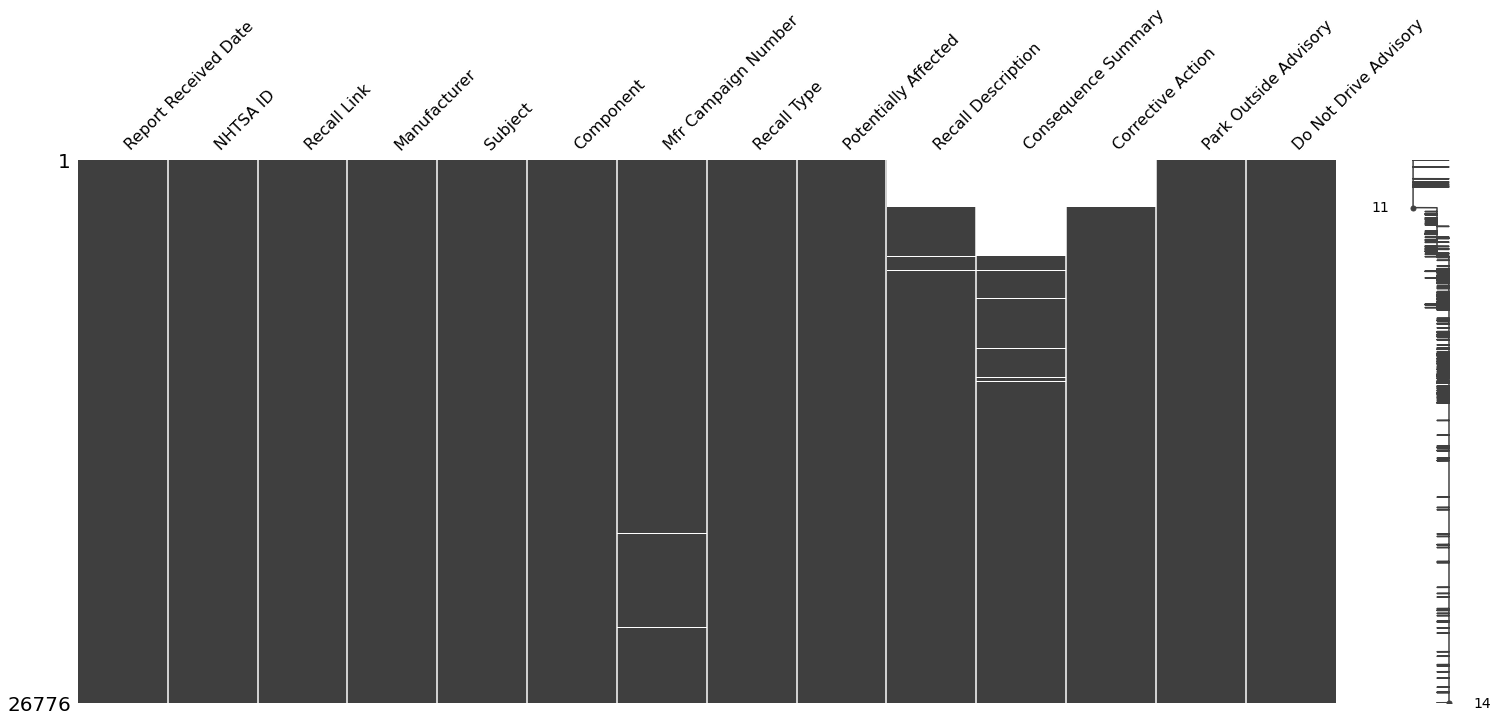

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26776 entries, 26775 to 0
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Report Received Date    26776 non-null  datetime64[ns]
 1   NHTSA ID                26776 non-null  object        
 2   Recall Link             26776 non-null  object        
 3   Manufacturer            26776 non-null  object        
 4   Subject                 26776 non-null  object        
 5   Component               26776 non-null  object        
 6   Mfr Campaign Number     26747 non-null  object        
 7   Recall Type             26776 non-null  object        
 8   Potentially Affected    26733 non-null  float64       
 9   Recall Description      24375 non-null  object        
 10  Consequence Summary     21888 non-null  object        
 11  Corrective Action       24388 non-null  object        
 12  Park Outside Advisory   26776 non-null  object

In [8]:
#Visualising missing data

#Sorting values by report received date
recalls_raw = recalls_raw.sort_values(by='Report Received Date',ascending=True)

#plotting matrix of missing data
msno.matrix(recalls_raw)
plt.show()

#info of sorted data
print(recalls_raw.info())

This visualisation is further refined once the rows with no "Potentially Affected" units are scrubbed from the dataset:

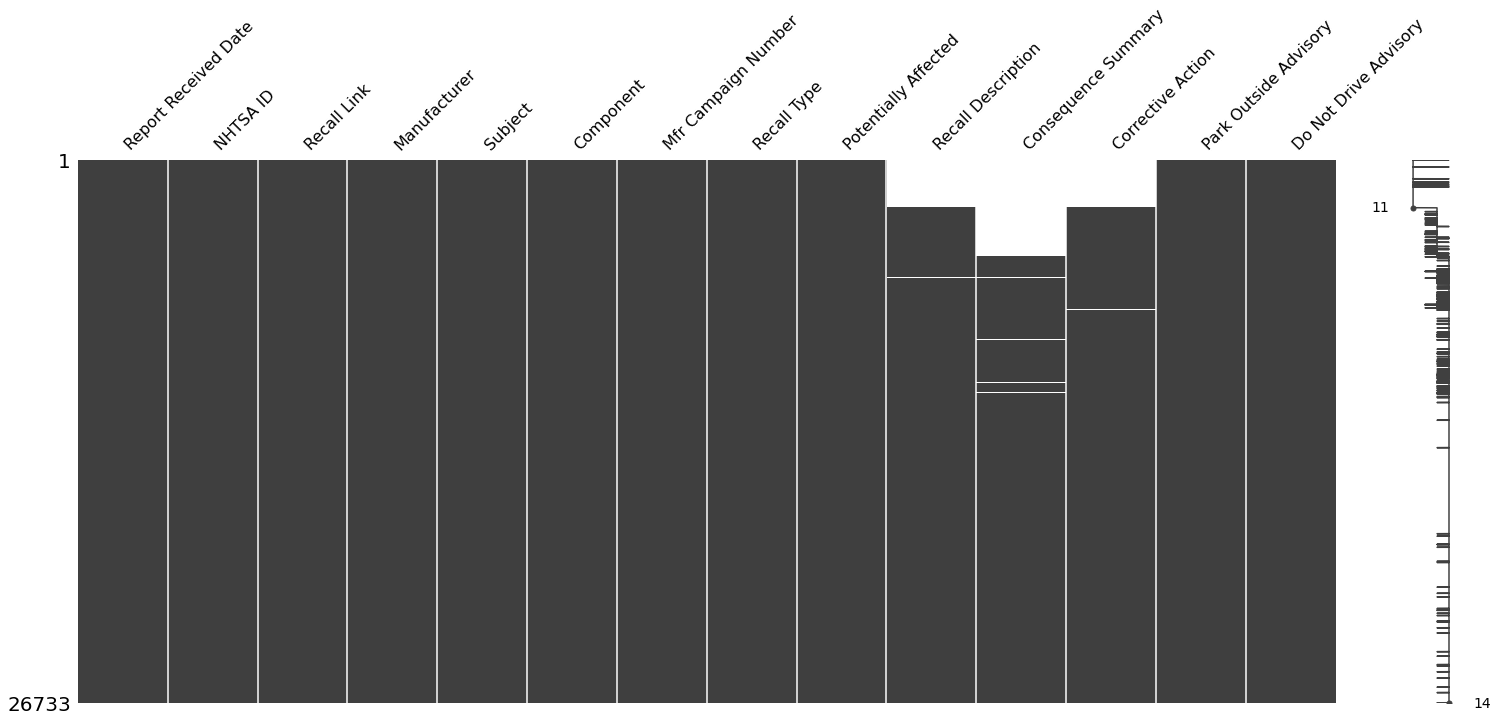

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26733 entries, 26775 to 0
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Report Received Date    26733 non-null  datetime64[ns]
 1   NHTSA ID                26733 non-null  object        
 2   Recall Link             26733 non-null  object        
 3   Manufacturer            26733 non-null  object        
 4   Subject                 26733 non-null  object        
 5   Component               26733 non-null  object        
 6   Mfr Campaign Number     26704 non-null  object        
 7   Recall Type             26733 non-null  object        
 8   Potentially Affected    26733 non-null  float64       
 9   Recall Description      24332 non-null  object        
 10  Consequence Summary     21845 non-null  object        
 11  Corrective Action       24345 non-null  object        
 12  Park Outside Advisory   26733 non-null  object

In [9]:
#dropping rows with missing 'Potentially Affected' data - irrelevant for analysis
recalls_raw = recalls_raw.dropna(subset = ['Potentially Affected'])

#plotting matrix of missing data
msno.matrix(recalls_raw)
plt.show()

#info of sorted data
print(recalls_raw.info())

We can see that only the columns 'Mfr Campaign Number', 'Recall Description', 'Consequence Summary', and 'Corrective Action' now have missing data; we can also note that only the earliest entries in the dataset have missing values. This can be cleaned up using the fillna function, subbing in "Missing_Info" for any blank entries.

Once this is done, we can see from the msno matrix that we now have a dataset with no blank entries:

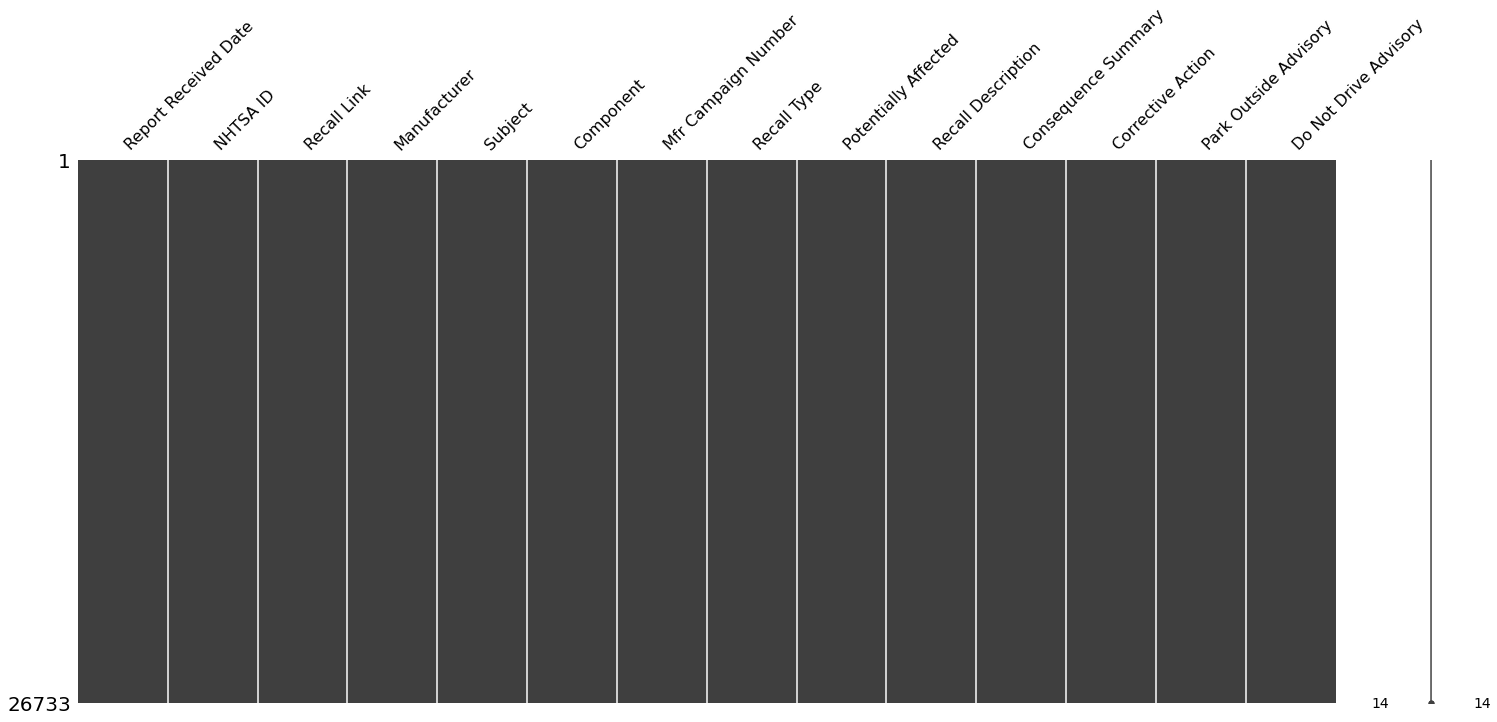

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26733 entries, 26775 to 0
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Report Received Date    26733 non-null  datetime64[ns]
 1   NHTSA ID                26733 non-null  object        
 2   Recall Link             26733 non-null  object        
 3   Manufacturer            26733 non-null  object        
 4   Subject                 26733 non-null  object        
 5   Component               26733 non-null  object        
 6   Mfr Campaign Number     26733 non-null  object        
 7   Recall Type             26733 non-null  object        
 8   Potentially Affected    26733 non-null  float64       
 9   Recall Description      26733 non-null  object        
 10  Consequence Summary     26733 non-null  object        
 11  Corrective Action       26733 non-null  object        
 12  Park Outside Advisory   26733 non-null  object

In [10]:
#filling in missing text data in text columns 
#text_cols = recalls_raw[['Recall Description','Consequence Summary','Corrective Action']]
recalls_raw = recalls_raw.fillna(value = 'missing_info')

#plotting matrix of missing data
msno.matrix(recalls_raw)
plt.show()

#info of sorted data
print(recalls_raw.info())

## NLP Column Analysis: Corrective Action  

Next we prepare for some natural language processing (NLP) work on the "Corrective Actions" column, by first defining the stopwords to ignore during the language processing, and then the tokenising and lemmatising functions to pick out keywords in the text.   

The stopwords file is contained in the text file 'excluded_words.txt', also contained in this folder; the WhitespaceTokenizer function is a tokeniser that uses whitespace as a delimiter to break up text into individual words or tokens, while WordNetLemmatizer is a tool for reducing inflected words to their base or root form (the "lemma"). 

Unfortunately a trial of different lemmatising functions has shown that it doesn't pick up all inflections in the text, so further processing will be done in later stages, to swap out inflections and synonyms using a dictionary.

In [11]:
#NLP prep - defining NLTK functions

#reading in stopwords txt file to list
stopwords_file = 'excluded_words.txt'
stopwords_filepath = os.path.join(dir_name, stopwords_file)

with open(stopwords_filepath) as file:
    stopwords = set(file.read().split())

#defining tokenising and lemmatising functions from NLTK
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text) if w.lower() not in stopwords]


Along with this we define supplementary functions for text processing, to remove numbers, replace inflections or synonyms based on an inflection dictionary, filter out keywords, remove duplicate words in a column, and expand information in postprocessing:

In [12]:
#removing numbers in the analysis column
def remove_num(text):
    return re.sub(r'\d+', '', text)

#function to replace inflections
def replace_inflections(string):
    for inflection, replacement in inflect_dict.items():
        string = string.replace(inflection, replacement)
    return string

#function to remove words not found in the keywords list
def filter_keywords(row, wordlist):
    # split the row into individual words
    words = row.split()
    # create a new list with only the words in the word_list
    filtered_words = [word for word in words if word in wordlist]
    #if no keywords found, add 'No Classification'
    if len(filtered_words) == 0:
        filtered_words.append('no_classification')
    # join the filtered words back together into a string
    filtered_row = ' '.join(filtered_words)
    return filtered_row

#function to remove duplicate words in the classification column
def remove_duplicate_words(text):
    words = text.split()
    unique_words = list(set(words))
    return ' '.join(unique_words)

#function to expand keyword info
def info_expand(val):
    for keyword, info in key_info.items():
        val = val.replace(keyword, info)
    return val


Following this we clean the data, lemmatise the text, and convert the text to lowercase. The resulting lemmatised text is stored in a new column called "CA Lemm".

In [13]:
#creating new column in df for NLP analysis

#punctuation list
punct = '[' + string.punctuation + ']'

#removing punctuation and lemmatising column
recalls_raw['CA Lemm'] = recalls_raw['Corrective Action'].str.replace(punct,'',regex=True).apply(lemmatize_text) 

#converting column type to lowercase string for further analysis
recalls_raw['CA Lemm'] = recalls_raw['CA Lemm'].apply(str).apply(str.lower).str.replace(punct,'',regex=True)

The counter function gives us an idea of the most common tokens found in the text, printing the count of instances for each word:

In [14]:
Counter(" ".join(recalls_raw["CA Lemm"]).split()).most_common(20)

[('recall', 19802),
 ('service', 12029),
 ('replace', 10569),
 ('notify', 9068),
 ('inspect', 4834),
 ('notification', 4754),
 ('install', 3582),
 ('vehicles', 3105),
 ('remedy', 2970),
 ('safety', 2784),
 ('repair', 2749),
 ('vehicle', 2587),
 ('mailed', 2407),
 ('missinginfo', 2388),
 ('letter', 2358),
 ('brake', 2030),
 ('receive', 1944),
 ('replaced', 1830),
 ('affected', 1805),
 ('fuel', 1735)]

We can see that the lemmatising function hasn't picked up all inflections (for example, the words 'notification' and replaced', which should have been converted to 'notify' and 'replace' respectively). Subsequently we can define an inflection dictionary (also included in the folder) to catch these stray inflections and convert them to the format we need for analysis:

In [15]:
#postprocessing lemmatised words to reduce variations with word inflections
with open('inflect_dict.txt','r') as f:
    inflect_dict = json.load(f)

#applying to column
recalls_raw["CA Lemm"] = recalls_raw["CA Lemm"].apply(replace_inflections)

Applying the remove_num function lets us strip out all numbers in the text: 

In [16]:
#applying both functions to the Corrective Action Analysis column
recalls_raw['CA Lemm'] = recalls_raw['CA Lemm'].apply(remove_num)

The majority of the lemmatised rows in 'CA Lemm' now contains at least one keyword, or 'missing info'. 

Now we filter the 'CA Lemm' column to only keep words contained in the keywords, by first loading in the 'keywords.txt' file; this file will be used to flag words in the 'CA Lemm' column that indicate a key action taken during the recall, i.e. inspect, replace, etc. We apply this to the column using the filter_keywords function - in the process creating a new column, 'CA Keywords'. This column is cleaned up by removing duplicates, before the values in each cell are sorted alphabetically. These steps will be useful when summarising the corrective actions in Power BI. 

We also print the number of unique values in the CA Keywords column using nunique():

In [17]:
# Open keywords file for reading
with open("keywords.txt", "r") as f:
    # Load the list from the file
    keywords = json.load(f)

#applying keywords filter to classification column
recalls_raw['CA Keywords'] = recalls_raw['CA Lemm'].apply(lambda w: filter_keywords(w, keywords))

#removing duplicate words in the entries
recalls_raw['CA Keywords'] = recalls_raw['CA Keywords'].apply(remove_duplicate_words)

# sort the values alphabetically for each row
recalls_raw['CA Keywords'] = recalls_raw['CA Keywords'].apply(lambda w: ' '.join(sorted(w.split())))

#print number of unique classifiers
print(recalls_raw['CA Keywords'].nunique())

280


A loop is applied to count the number of keywords found in the 'CA Keywords' column: 

In [18]:
#counting number of rows in the corrective action column that contain at least one keyword

match_count = 0

for row in recalls_raw["CA Keywords"]:
    for word in keywords:
        if word in row:
            match_count +=1
            break

print(match_count)
print(keywords)

25572
['service', 'notify', 'replace', 'refund', 'inspect', 'install', 'repair', 'missinginfo', 'remove', 'relocate', 'reprogram', 'modify', 'retrofit', 'adjust']


We then count the most common tokens in the 'CA Keywords' column:

In [19]:
keywords_instances = pd.DataFrame()

for comp in recalls_raw['Component'].unique():
    
    temp_df = recalls_raw[recalls_raw['Component']==comp]
    
    #Checking most common keywords found
    kw_inst = Counter(" ".join(temp_df["CA Keywords"]).split()).most_common(15)

    #converting to a dataframe for later analysis
    keywords_temp_df = pd.DataFrame(kw_inst,columns = ['Action Taken','Frequency'])
    
    keywords_temp_df['Component'] = str(comp)
    
    keywords_instances = pd.concat([keywords_instances,keywords_temp_df])

#printing dataframe
print(keywords_instances)

   Action Taken  Frequency                Component
0       replace        963                 STEERING
1        notify        725                 STEERING
2       service        604                 STEERING
3       inspect        425                 STEERING
4   missinginfo        313                 STEERING
..          ...        ...                      ...
3        repair          1            COMMUNICATION
4       inspect          1            COMMUNICATION
0        notify          2  TRACTION CONTROL SYSTEM
1       service          2  TRACTION CONTROL SYSTEM
2     reprogram          1  TRACTION CONTROL SYSTEM

[438 rows x 3 columns]


As a final sanity check, we subset the values in 'CA Lemm' with no keywords using another function defined earlier, subset_no_keywords. Printing the most common words gives a look at any potential keywords missing from the keywords file:

In [27]:
def subset_no_keywords(wordlist, data):
    return [row for row in data if all(word not in row for word in wordlist)]

recalls_no_keyword = subset_no_keywords(keywords,recalls_raw['CA Lemm']) 

In [21]:
Counter(" ".join(recalls_no_keyword).split()).most_common(20)

[('ricon', 278),
 ('correct', 218),
 ('please', 159),
 ('e', 152),
 ('recall', 144),
 ('wheelchair', 140),
 ('lifts', 124),
 ('air', 74),
 ('pressure', 67),
 ('vehicles', 55),
 ('valve', 53),
 ('brake', 51),
 ('system', 42),
 ('corrected', 39),
 ('relief', 39),
 ('remedy', 38),
 ('dryer', 38),
 ('prevent', 37),
 ('bus', 36),
 ('safety', 35)]

## Aggregating and Postprocessing CA Keywords 

Following the bulk of the NLP work, we tabulate the values in the 'CA Keywords' column to understand the most common sequence of actions across all recall instances:

In [22]:
#tabulating CA data
group_CA_Class = recalls_raw['CA Keywords'].value_counts()

#printing 20 most common
print(group_CA_Class.head(60))

notify replace service                    3634
replace                                   3268
missinginfo                               2388
notify replace                            1638
install                                   1547
notify service                            1183
no_classification                         1161
inspect notify replace service            1055
install notify service                    1050
inspect replace                            861
notify                                     621
inspect notify service                     520
notify repair                              413
install replace                            301
inspect notify replace                     296
repair replace service                     280
replace service                            272
repair                                     242
modify                                     230
install notify                             229
modify notify service                      227
notify repair

This gives us the information we're looking for, but it's somewhat clunky and difficult to read - we can apply some postprocessing to these entries to let us read this better, by adding commas and expanding on the information.

In [23]:
#adding in commas between keywords
recalls_raw['CA Keywords'] = recalls_raw['CA Keywords'].str.replace(' ',', ')

#reading in postprocessing dictionary, based on keywords
with open('key_info.txt','r') as f:
    key_info = json.load(f)

#applying to column
recalls_raw["CA Keywords"] = recalls_raw["CA Keywords"].apply(info_expand)

#also applying to keywords_instances dataframe
keywords_instances['Action Taken'] = keywords_instances['Action Taken'].apply(info_expand)

We rerun the tabulation to see the updated data:

In [24]:
#tabulating CA data
group_CA_Class = recalls_raw['CA Keywords'].value_counts()

#printing 20 most common
print(group_CA_Class.head(60))

notify owner, replace unit/part, service unit                                3634
replace unit/part                                                            3268
missing info                                                                 2388
notify owner, replace unit/part                                              1638
install part                                                                 1547
notify owner, service unit                                                   1183
no classification                                                            1161
inspect unit, notify owner, replace unit/part, service unit                  1055
install part, notify owner, service unit                                     1050
inspect unit, replace unit/part                                               861
notify owner                                                                  621
inspect unit, notify owner, service unit                                      520
notify owner, re

## Export Data for Power BI Analysis

Now that processing is complete on the recalls dataset, we filter the columns to only include the columns we need for visualisation and analysis. This filtered dataset will be stored in the recalls_processed dataframe, and then printed to a csv file for Power BI visualisation: 

In [25]:
#creating filtered dataset
recalls_processed = recalls_raw[['Report Received Date', 'NHTSA ID','Manufacturer',
       'Subject', 'Component', 'Mfr Campaign Number', 'Recall Type',
       'Potentially Affected', 'Recall Description', 'Consequence Summary',
       'Corrective Action', 'Park Outside Advisory ', 'Do Not Drive Advisory',
       'CA Keywords']]

#exporting to csv for PBI report
recalls_processed.to_csv('pbi_recalls_data.csv',index=False)

We also print the keywords_instances dataframe to a csv, as this will be useful data for a dashboard:

In [26]:
#exporting to csv for PBI report
keywords_instances.to_csv('pbi_keywords_data.csv',index=False)

The data is now sufficiently cleaned and ready for the next step - a Power BI dashboard for quick business analysis. This dashboard can also be found in the github repository for this project.